# Electricity Demand Estimation For Leading Electricity Distributor

In [3]:
import numpy as np
import pandas as pd
import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.tsa.seasonal import seasonal_decompose
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import naive, drift, mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf_ols
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math

In [1]:
#Downgrading Statsmodels to get Forecast Function from stldecompose!
!pip install statsmodels==0.10.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.1 MB 4.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.8.0 requires statsmodels>=0.12.1, but you have statsmodels 0.10.2 which is incompatible.


In [2]:
#Installation of Stldecompose!
!pip install stldecompose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Importing Dataset in Google Collab!
from google.colab import files
uploaded=files.upload()

Saving Electricity Consumption.csv to Electricity Consumption.csv


In [5]:
ec=pd.read_csv('Electricity Consumption.csv')
ec

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [6]:
#Checking Info!
ec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [7]:
#Storing only Electricity Consumption Values!
ed1=ec.Electricty_Consumption_in_TW

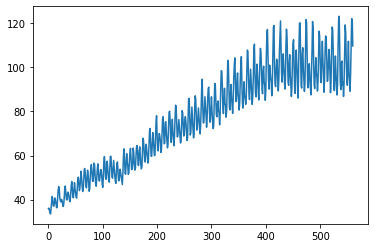

In [8]:
#Plotting the EC Values to see trend and seasonality!
ed1.plot()

In [9]:
#Converting Date Index to DateTime Data type!
ec.DATE=pd.to_datetime(ec.DATE, format='%m-%d-%Y',infer_datetime_format=True)

In [10]:
#Setting the index as DateTime Index!
ec.set_index(ec.DATE, inplace=True)

In [11]:
ec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


In [12]:
#Adding Columns of Year and Month from Date!
ec['year'] = ec.DATE.dt.year
ec['month'] = ec.DATE.dt.month

In [13]:
ec

,DATE,Electricty_Consumption_in_TW,year,month
DATE,,,,
1973-01-01,1973-01-01,35.9728,1973,1
1973-02-01,1973-02-01,36.1334,1973,2
1973-03-01,1973-03-01,35.0625,1973,3
1973-04-01,1973-04-01,33.8416,1973,4
1973-05-01,1973-05-01,33.5107,1973,5
...,...,...,...,...
2019-05-01,2019-05-01,97.5860,2019,5
2019-06-01,2019-06-01,110.8580,2019,6
2019-07-01,2019-07-01,122.1014,2019,7


In [14]:
#Analyzing Electricity Consumption on Yearly Basis! 
pd.pivot_table(data = ec, index = 'year', columns = 'month', values = 'Electricty_Consumption_in_TW')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1973,35.9728,36.1334,35.0625,33.8416,33.5107,36.4823,39.1412,41.4137,40.1639,37.1133,37.0248,38.4341
1974,40.7455,39.8340,37.9408,36.3004,36.5293,40.8899,44.3563,45.9240,44.4555,40.6417,39.4901,38.9068
1975,40.0956,39.6944,38.3040,36.8939,37.5668,40.3832,44.9671,46.1853,43.3001,40.3836,39.8092,42.0597
1976,43.4099,42.5826,40.9244,39.3533,39.0766,42.4851,46.3693,48.1945,45.1688,41.1880,40.8431,44.1468
1977,47.6892,44.8505,42.8557,41.0177,40.7201,45.0610,48.9685,50.1898,47.5982,44.0684,45.4267,49.3447
1978,52.9153,49.9488,46.1749,43.6652,44.5402,48.9480,53.8292,54.1182,50.9980,46.3711,45.3267,49.0027
1979,53.3617,51.6279,47.8264,43.7935,44.8591,50.3292,54.3579,55.9197,53.5776,48.7261,48.2585,51.3008
1980,56.5838,55.6802,50.4428,46.8693,46.0886,49.7595,53.8273,56.2272,52.5737,48.8947,48.4081,50.6659
1981,53.5867,53.5461,51.0708,46.9172,45.5795,50.0235,57.1384,59.5376,56.1935,50.3249,49.2234,52.8176


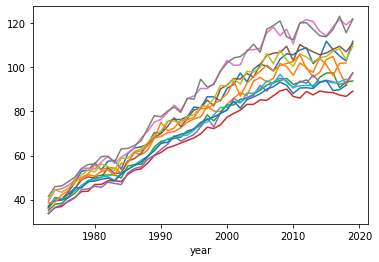

In [15]:
#Visualizing Yearly basis increase in Electricity Consumption!
pd.pivot_table(data = ec, index = 'year', columns = 'month', values = 'Electricty_Consumption_in_TW').plot(legend=False)

In [16]:
#Analyzing Electricity Consumption on Monthly Basis! 
pd.pivot_table(data = ec, index = 'month', columns = 'year', values = 'Electricty_Consumption_in_TW')

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
month,,,,,,,,,,,,,,,,,,,,,
1,35.9728,40.7455,40.0956,43.4099,47.6892,52.9153,53.3617,56.5838,53.5867,57.4002,...,105.7413,107.8967,108.9151,101.6890,104.3752,111.8708,108.1515,105.1879,102.9398,111.8520
2,36.1334,39.8340,39.6944,42.5826,44.8505,49.9488,51.6279,55.6802,53.5461,54.6248,...,96.4428,101.9572,100.0117,95.5366,97.7907,103.4990,104.9900,98.0069,92.0095,97.3261
3,35.0625,37.9408,38.3040,40.9244,42.8557,46.1749,47.8264,50.4428,51.0708,51.1896,...,92.2986,93.2285,94.3484,91.0434,95.5280,97.4134,97.5969,90.8029,93.3526,93.8406
4,33.8416,36.3004,36.8939,39.3533,41.0177,43.6652,43.7935,46.8693,46.9172,48.4958,...,86.8242,86.0874,89.0821,87.5189,89.2783,88.7323,88.5477,87.4594,86.8386,89.1873
5,33.5107,36.5293,37.5668,39.0766,40.7201,44.5402,44.8591,46.0886,45.5795,47.9140,...,90.6389,93.7706,92.7937,96.5166,93.2729,94.1360,93.5168,92.2811,93.2361,97.5860
6,36.4823,40.8899,40.3832,42.4851,45.0610,48.9480,50.3292,49.7595,50.0235,54.5292,...,103.0377,110.3572,108.5421,107.0627,105.7336,106.5504,108.1813,109.6104,107.1009,110.8580
7,39.1412,44.3563,44.9671,46.3693,48.9685,53.8292,54.3579,53.8273,57.1384,59.5975,...,110.6045,120.1457,121.6974,120.8149,116.4651,114.2235,118.3568,121.7478,119.2874,122.1014
8,41.4137,45.9240,46.1853,48.1945,50.1898,54.1182,55.9197,56.2272,59.5376,59.6727,...,112.5792,120.2087,120.2822,117.2932,114.3700,113.9230,117.1375,123.2163,115.7108,121.7765
9,40.1639,44.4555,43.3001,45.1688,47.5982,50.9980,53.5776,52.5737,56.1935,54.9644,...,100.4701,106.1109,104.6692,102.4185,104.3899,104.9454,107.3046,108.4514,103.4070,109.7190


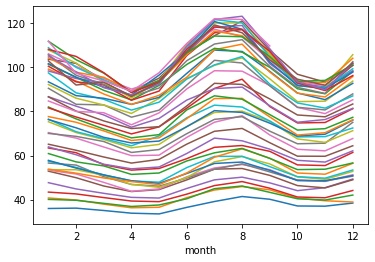

In [17]:
#Visualizing the Trend and Seasonality on Monthly Basis!
pd.pivot_table(data = ec, index = 'month', columns = 'year', values = 'Electricty_Consumption_in_TW').plot(legend=False)

In [18]:
#Storing only EC Values!
ed=ec.iloc[:,1]

In [19]:
#Decomposition of Data for Trend and Seasonality!
decom = seasonal_decompose(ed, model='additive')

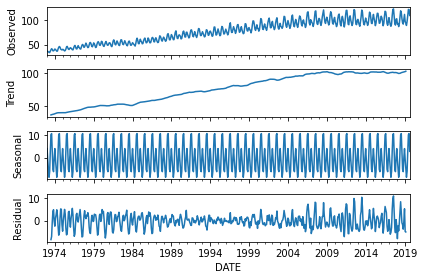

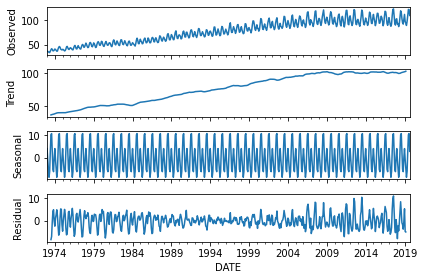

In [20]:
#Plotting the Decomposition Componenets!
decom.plot()

In [21]:
#Extracting the Observed, Trend, Seasonal, Irregular values and storing it in Decomposed!
decomposed = pd.concat([decom.observed, decom.trend, decom.seasonal, decom.resid], axis=1).head(20)
decomposed.columns = ['Actual', 'Trend', 'Seasonality', 'Irregular']
decomposed
#Trend and Irregular values of first 6 months are Nan because it takes Moving Average!
#Actual values are additive combination of trend, seasonality, and Irregular values!

,Actual,Trend,Seasonality,Irregular
DATE,,,,
1973-01-01,35.9728,NaN,4.135755,NaN
1973-02-01,36.1334,NaN,-0.705922,NaN
1973-03-01,35.0625,NaN,-4.489678,NaN
1973-04-01,33.8416,NaN,-8.668415,NaN
1973-05-01,33.5107,NaN,-6.044817,NaN
1973-06-01,36.4823,NaN,2.943116,NaN
1973-07-01,39.1412,37.223388,10.277826,-8.360014
1973-08-01,41.4137,37.576442,10.828421,-6.991163
1973-09-01,40.1639,37.850562,2.891998,-0.578660


In [22]:
#Decomposition through Decompose Function from stldecompose package!
decom1 = decompose(ed)

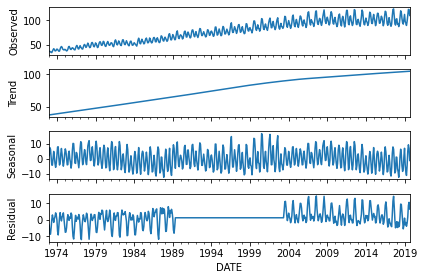

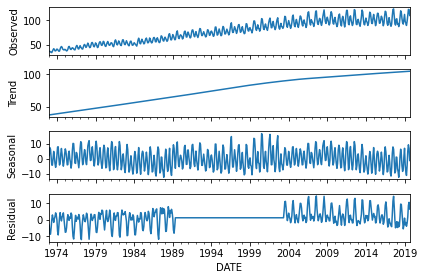

In [23]:
decom1.plot()

In [24]:
#Extracting the Observed, Trend, Seasonal, Irregular values and storing it in stl_decom_values!
stl_decom_values = pd.concat([decom1.observed, decom1.trend, decom1.seasonal, decom1.resid], axis=1).head(20)
stl_decom_values.columns = ['Actual', 'Trend', 'Seasonality', 'Irregular']
stl_decom_values
#Actual values are additive combination of trend, seasonality, and Irregular values!

,Actual,Trend,Seasonality,Irregular
DATE,,,,
1973-01-01,35.9728,37.267425,1.997755,-3.292380
1973-02-01,36.1334,37.408595,7.239741,-8.514936
1973-03-01,35.0625,37.549765,6.266477,-8.753742
1973-04-01,33.8416,37.690935,1.018764,-4.868098
1973-05-01,33.5107,37.832105,-4.190450,-0.130955
1973-06-01,36.4823,37.973275,-4.332364,2.841389
1973-07-01,39.1412,38.114503,0.572428,0.454269
1973-08-01,41.4137,38.255731,4.807320,-1.649351
1973-09-01,40.1639,38.396960,1.354862,0.412078


### Train and Test Split

In [25]:
train_data=ec.Electricty_Consumption_in_TW[:'2019-03-01']
train_data

DATE
1973-01-01     35.9728
1973-02-01     36.1334
1973-03-01     35.0625
1973-04-01     33.8416
1973-05-01     33.5107
                ...   
2018-11-01     91.9079
2018-12-01    101.9883
2019-01-01    111.8520
2019-02-01     97.3261
2019-03-01     93.8406
Name: Electricty_Consumption_in_TW, Length: 555, dtype: float64

In [26]:
#Storing last 6 months of data as test data!
test_data=ec.Electricty_Consumption_in_TW['2019-04-01':]
test_data

DATE
2019-04-01     89.1873
2019-05-01     97.5860
2019-06-01    110.8580
2019-07-01    122.1014
2019-08-01    121.7765
2019-09-01    109.7190
Name: Electricty_Consumption_in_TW, dtype: float64

### Forecasting using STL Forecast()

In [27]:
#Decomposing Train Data for Forcasting!
decom_train = decompose(train_data, period = 12)

In [28]:
decom_train.observed

DATE
1973-01-01     35.9728
1973-02-01     36.1334
1973-03-01     35.0625
1973-04-01     33.8416
1973-05-01     33.5107
                ...   
2018-11-01     91.9079
2018-12-01    101.9883
2019-01-01    111.8520
2019-02-01     97.3261
2019-03-01     93.8406
Name: Electricty_Consumption_in_TW, Length: 555, dtype: float64

In [29]:
#Forecasting for last 6 months using Decom_Train values!
fcast_6m=forecast(decom_train, steps = 6, fc_func = drift, seasonal = True)
fcast_6m.columns=['Forecast']
fcast_6m

,Forecast
2019-03-29,95.370935
2019-04-26,97.974545
2019-05-24,106.881528
2019-06-21,114.360512
2019-07-19,114.978310
2019-08-16,107.093695


In [30]:
#Concatinating the Actual and Forecast values to observe the accuracy of Forecasted Values!
fcast_test = pd.concat([pd.DataFrame(test_data).reset_index(),pd.DataFrame(fcast_6m.values)], axis = 1)

In [31]:
fcast_test.set_index(fcast_test.DATE, inplace=True)

In [32]:
fcast_test.drop('DATE', axis = 1, inplace = True)

In [33]:
fcast_test.columns = ['Actual', 'Forecast']
fcast_test

,Actual,Forecast
DATE,,
2019-04-01,89.1873,95.370935
2019-05-01,97.5860,97.974545
2019-06-01,110.8580,106.881528
2019-07-01,122.1014,114.360512
2019-08-01,121.7765,114.978310
2019-09-01,109.7190,107.093695


### RMSE, RMSPE and MAPE Calculations for Stdl Decomposition

In [34]:
mse=np.square(np.subtract(fcast_test.Actual,fcast_test.Forecast)).mean() 

In [35]:
RMSE = math.sqrt(mse)
print('RMSE for Stdl Decomposition :' ,RMSE)

RMSE for Stdl Decomposition : 5.279356052010394


In [36]:
print('RMSPE for Stdl Decomposition: ',np.sqrt(np.mean(np.square(((fcast_test.Actual - fcast_test.Forecast) / fcast_test.Actual))))*100)

RMSPE for Stdl Decomposition:  4.798918209143085


In [37]:
print('MAPE for Stdl Decomposition: ',np.mean(np.abs((fcast_test.Actual - fcast_test.Forecast) / fcast_test.Actual))* 100)

MAPE for Stdl Decomposition:  4.205575789935018


### ETS Model

In [38]:
#UDF Function for getting best alpha, beta, gamma values with low error!
from sklearn.metrics import mean_absolute_error

def auto_hwm(timeseries, val_split_date, alpha=[None], beta=[None], gamma=[None], 
              trend=None, seasonal=None, periods=None, verbose=False):

    best_params = []
    actual = timeseries[val_split_date:]

    print('Evaluating Exponential Smoothing model for', len(alpha) * len(beta) * len(gamma), 'fits\n')

    for a in alpha:
        for b in beta:
            for g in gamma:
                    if(verbose == True):
                        print('Checking for', {'alpha': a, 'beta': b, 'gamma': g})

                    model = ExponentialSmoothing(timeseries, trend=trend, seasonal=seasonal, seasonal_periods=periods)
                    model.fit(smoothing_level=a, smoothing_slope=b, smoothing_seasonal=g)
                    f_cast = model.predict(model.params, start=actual.index[0])
                    score = np.where(np.float64(mean_absolute_error(fcast_test.Actual , fcast_test.Forecast) / fcast_test.Actual).mean()>0,np.float64(mean_absolute_error(fcast_test.Actual , fcast_test.Forecast) / fcast_test.Actual).mean(),0)

                    best_params.append({'alpha': a, 'beta': b, 'gamma': g, 'mae': score})

    return min(best_params, key=lambda x: x['mae'])

alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
beta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
gamma =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

auto_hwm(ec.Electricty_Consumption_in_TW, val_split_date ='2019-04-01' , alpha=alpha, beta=beta, gamma=gamma, 
              trend='mul', seasonal='mul', periods=12, verbose=True)

Evaluating Exponential Smoothing model for 729 fits

Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.7}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-


Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: Va

Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:865: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + \
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:875: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueW

Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/usr/local/lib/python3.7/dist-p

Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.6}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.4}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.2}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.7}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.5}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.3}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/usr/local/lib/python3.7/dist-p

Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.1}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.7/dist-packages/stat

Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.8}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.9}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


{'alpha': 0.1, 'beta': 0.1, 'gamma': 0.1, 'mae': array(0.0431062)}

In [39]:
#Setting up the Model with the best Alpha, Beta, Gamma values!
ets_model1 = ExponentialSmoothing(train_data,trend='mul', seasonal='mul',seasonal_periods=12).fit(smoothing_level=0.1,#alpha
                                                                                                  smoothing_slope=0.1,#beta
                                                                                                  smoothing_seasonal=0.1)#gamma

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [40]:
print(ets_model1.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  555
Model:             ExponentialSmoothing   SSE                           2777.853
Optimized:                         True   AIC                            925.808
Trend:                   Multiplicative   BIC                            994.912
Seasonal:                Multiplicative   AICC                           927.084
Seasonal Periods:                    12   Date:                 Tue, 22 Nov 2022
Box-Cox:                          False   Time:                         14:03:01
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_slope          

In [41]:
#Separating Actual Train and Predicted Train for calculation of Train Error!
act_train=train_data['2018-04-01':].values

In [42]:
#Fitted Values for train_data which are predicted values for train!
pred_train=ets_model1.fittedvalues['2018-04-01':].values

In [43]:
#Separating Actual Test and Predicted Test for calculation of Test Error!
act_test=test_data.values

In [44]:
#Forecasting values using the ets_model1 which is predicted test!
pred_test=ets_model1.forecast(6).values

### RMSE, RMSPE and MAPE calculations for ETS Model

In [45]:
mse_ets=np.square(np.subtract(act_train,pred_train)).mean()
RMSE_ets = math.sqrt(mse_ets)
print('RMSE for ETS Model [Train_Data] :' ,RMSE_ets)

RMSE for ETS Model [Train_Data] : 2.5372006069432853


In [46]:
mse_ets1=np.square(np.subtract(act_test,pred_test)).mean()
RMSE_ets1 = math.sqrt(mse_ets1)
print('RMSE for ETS Model [Test_Data] :' ,RMSE_ets1)

RMSE for ETS Model [Test_Data] : 4.098419673652687


In [47]:
print('RMSPE for ETS Model[Train_Data]: ',np.sqrt(np.mean(np.square(((act_train - pred_train) / act_train))))*100)
print('RMSPE for ETS Model[Test_Data]: ',np.sqrt(np.mean(np.square(((act_test - pred_test) / act_test))))*100)

RMSPE for ETS Model[Train_Data]:  2.337882398934739
RMSPE for ETS Model[Test_Data]:  3.637537843454723


In [48]:
print('MAPE for ETS Model[Train_Data]: ',np.mean(np.abs((act_train - pred_train) / act_train))* 100)
print('MAPE for ETS Model[Test_Data]: ',np.mean(np.abs((act_test - pred_test) / act_test))* 100)

MAPE for ETS Model[Train_Data]:  1.761486488576675
MAPE for ETS Model[Test_Data]:  3.4053541164023273


### ARIMA Model

In [49]:
# Dickey-Fuller test can also help with finding whether my series is stationary of not

adfuller(train_data) #p-value is greater than 0.05 we cannot reject null hypothesis ,Series is not stationary!

(-2.0106179030223723,
 0.2819370122673489,
 15,
 539,
 {'1%': -3.4425405682241816,
  '5%': -2.8669171671779816,
  '10%': -2.5696338432333636},
 2270.322530165816)

In [50]:
adfuller(np.log(train_data)) # we can reject null hypothesis, Series is stationary with LOG Transformation!

(-3.1717815761805013,
 0.021677286153780718,
 15,
 539,
 {'1%': -3.4425405682241816,
  '5%': -2.8669171671779816,
  '10%': -2.5696338432333636},
 -2485.737664809179)

In [51]:
#Log Transformation of Train and Test Data!
log_train=np.log(train_data)
log_test=np.log(test_data)

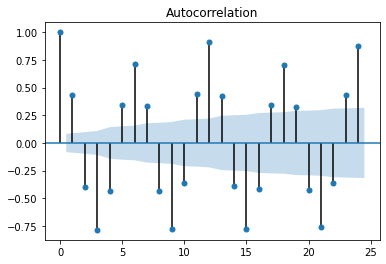

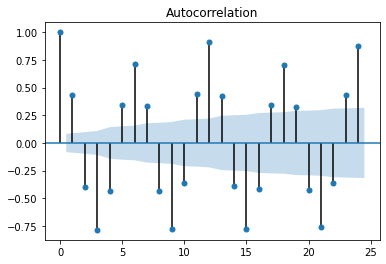

In [53]:
#ACF Plot!
smt.graphics.plot_acf(log_train,lags=24)

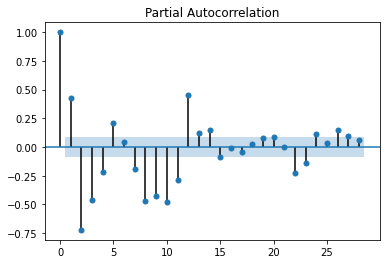

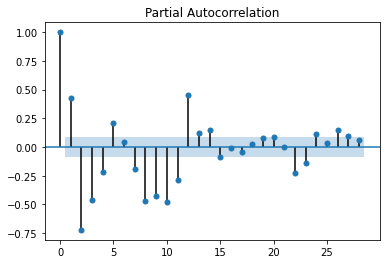

In [54]:
#PACF Plot!
smt.graphics.plot_pacf(log_train)

In [162]:
#Setting up and Fitting the Arima Model!
model_arima=sm.tsa.ARIMA(log_train, order =(1,0,1)).fit()
#p=1 as in PACF plot from +ve to -ve is from index 1!
#d=0 as there is no differencing!
#q=1 as in ACF plot +ve to -ve is from index 1!

In [163]:
print(model_arima.summary())

                                   ARMA Model Results                                   
Dep. Variable:     Electricty_Consumption_in_TW   No. Observations:                  555
Model:                               ARMA(1, 1)   Log Likelihood                 784.118
Method:                                 css-mle   S.D. of innovations              0.059
Date:                          Tue, 22 Nov 2022   AIC                          -1560.237
Time:                                  15:53:05   BIC                          -1542.961
Sample:                              01-01-1973   HQIC                         -1553.488
                                   - 03-01-2019                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  4.2718      0.090     47.256      0.000    

In [171]:
#Storing the Actual and Predicted Train log values for Train error calculations!
act_train_ar=log_train['2018-04-01':].values
pred_train_ar=model_arima.fittedvalues['2018-04-01':].values

In [182]:
#Storing the Actual and Predicted Test log values  for Test error calculations!
act_test_ar=log_test.values
pred_test_ar=model_arima.forecast(6)[0]

### RMSE,RMSPE and MAPE Calculations for Arima Model

In [193]:
mse_arima=np.square(np.subtract(act_train_ar,pred_train_ar)).mean()
RMSE_arima = math.sqrt(mse_arima)
print('RMSE for ARIMA Model[Train_Data] :' ,RMSE_arima)

RMSE for ARIMA Model[Train_Data] : 0.08770788780750341


In [194]:
mse_arima1=np.square(np.subtract(act_test_ar,pred_test_ar)).mean()
RMSE_arima1 = math.sqrt(mse_arima1)
print('RMSE for ARIMA Model[Test_Data] :' ,RMSE_arima1)

RMSE for ARIMA Model[Test_Data] : 0.18596985662531948


In [195]:
print('RMSPE for ARIMA Model[Train_Data]: ',np.sqrt(np.mean(np.square(((act_train_ar - pred_train_ar) / act_train_ar))))*100)
print('RMSPE for ARIMA Model[Test_Data]: ',np.sqrt(np.mean(np.square(((act_test_ar - pred_test_ar) / act_test_ar))))*100)

RMSPE for ARIMA Model[Train_Data]:  1.9113924521624854
RMSPE for ARIMA Model[Test_Data]:  3.9054202807780247


In [196]:
print('MAPE for ARIMA Model[Train_Data]: ',np.mean(np.abs((act_train_ar - pred_train_ar) / act_train_ar))* 100)
print('MAPE for ARIMA Model[Test_Data]: ',np.mean(np.abs((act_test_ar - pred_test_ar) / act_test_ar))* 100)


MAPE for ARIMA Model[Train_Data]:  1.6755681454327997
MAPE for ARIMA Model[Test_Data]:  3.421902326897561


### RMSE,RMSPE and MAPE Calculation after Exponential Transformation

In [177]:
#Exponential Transformation of Actual and Predicted Train values!
act_train_ar_or=np.exp(log_train['2018-04-01':]).values
pred_train_ar_or=np.exp(model_arima.fittedvalues['2018-04-01':]).values

In [185]:
#Exponential Transformation of Actual and Predicted Test values!
act_test_ar_or=np.exp(log_test).values
pred_test_ar_or=np.exp(model_arima.forecast(6)[0])

In [197]:
mse_arima2=np.square(np.subtract(act_train_ar_or,pred_train_ar_or)).mean()
RMSE_arima2 = math.sqrt(mse_arima1)
print('RMSE for ARIMA Model[Train_Data] :' ,RMSE_arima2)

RMSE for ARIMA Model[Train_Data] : 0.18596985662531948


In [198]:
mse_arima3=np.square(np.subtract(act_test_ar_or,pred_test_ar_or)).mean()
RMSE_arima3 = math.sqrt(mse_arima1)
print('RMSE for ARIMA Model[Test_Data] :' ,RMSE_arima3)

RMSE for ARIMA Model[Test_Data] : 0.18596985662531948


In [199]:
print('RMSPE for ARIMA Model[Train_Data]: ',np.sqrt(np.mean(np.square(((act_train_ar_or - pred_train_ar_or) / act_train_ar_or))))*100)
print('RMSPE for ARIMA Model[Test_Data]: ',np.sqrt(np.mean(np.square(((act_test_ar_or - pred_test_ar_or) / act_test_ar_or))))*100)

RMSPE for ARIMA Model[Train_Data]:  8.737253547876902
RMSPE for ARIMA Model[Test_Data]:  16.672708794874058


In [200]:
print('MAPE for ARIMA Model[Train_Data]: ',np.mean(np.abs((act_train_ar_or - pred_train_ar_or) / act_train_ar_or))* 100)
print('MAPE for ARIMA Model[Test_Data]: ',np.mean(np.abs((act_test_ar_or - pred_test_ar_or) / act_test_ar_or))* 100)

MAPE for ARIMA Model[Train_Data]:  7.677313547973265
MAPE for ARIMA Model[Test_Data]:  14.738349678445504


### SARIMA Model

In [59]:
#UDF Function to get best p,d,q and P,D,Q values with low AIC!
import sys
import itertools
import warnings

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, temp_results.aic))
                
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [60]:
best_results = auto_arima(log_train,  p=range(0, 3), d=range(2, 3), q=range(0, 3),
                         P=range(0, 3), D=range(0, 2), Q=range(0, 3))

SARIMAX(0, 2, 0)x(0, 0, 0, 12)12 - AIC:-1225.8907609596267
SARIMAX(0, 2, 0)x(0, 0, 1, 12)12 - AIC:-1539.746960519129
SARIMAX(0, 2, 0)x(0, 0, 2, 12)12 - AIC:-1621.3251514323467
SARIMAX(0, 2, 0)x(0, 1, 0, 12)12 - AIC:-1912.2050784360042
SARIMAX(0, 2, 0)x(0, 1, 1, 12)12 - AIC:-2093.1458290626397
SARIMAX(0, 2, 0)x(0, 1, 2, 12)12 - AIC:-2047.206903702459
SARIMAX(0, 2, 0)x(1, 0, 0, 12)12 - AIC:-1944.0038709088722
SARIMAX(0, 2, 0)x(1, 0, 1, 12)12 - AIC:-2146.741544539687
SARIMAX(0, 2, 0)x(1, 0, 2, 12)12 - AIC:-2093.8379764604724
SARIMAX(0, 2, 0)x(1, 1, 0, 12)12 - AIC:-1956.6143857762902
SARIMAX(0, 2, 0)x(1, 1, 1, 12)12 - AIC:-2090.7254683480296
SARIMAX(0, 2, 0)x(1, 1, 2, 12)12 - AIC:-2046.9288278469858
SARIMAX(0, 2, 0)x(2, 0, 0, 12)12 - AIC:-1963.7180031991152
SARIMAX(0, 2, 0)x(2, 0, 1, 12)12 - AIC:-2095.493919150576
SARIMAX(0, 2, 0)x(2, 0, 2, 12)12 - AIC:-2095.1019176031723
SARIMAX(0, 2, 0)x(2, 1, 0, 12)12 - AIC:-1980.6480008569556
SARIMAX(0, 2, 0)x(2, 1, 1, 12)12 - AIC:-2053.755549525199
SA

In [61]:
#Setting up and Fitting the model with best params!
model_sarima=sm.tsa.statespace.SARIMAX(log_train, order = (1,2,2), seasonal_order= (1,0,1,12),
                                       enforce_stationarity=False,enforce_invertibility=False).fit()

In [62]:
print(model_sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  555
Model:             SARIMAX(1, 2, 2)x(1, 0, 1, 12)   Log Likelihood                1312.532
Date:                            Tue, 22 Nov 2022   AIC                          -2613.064
Time:                                    14:18:36   BIC                          -2587.337
Sample:                                01-01-1973   HQIC                         -2603.001
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6205      0.048     13.005      0.000       0.527       0.714
ma.L1         -1.9279      0.054   

In [63]:
#Forecasting for Test Dataset!
sarima_forecast = model_sarima.forecast(6)
sarima_forecast

2019-04-01    4.470344
2019-05-01    4.531586
2019-06-01    4.676833
2019-07-01    4.776526
2019-08-01    4.769004
2019-09-01    4.652629
Freq: MS, dtype: float64

### RMSE, RMSPE and MAPE Calculations

In [206]:
#Storing the Actual and Predicted Train log values for Train error calculations!
act_train_sa_lg=log_train['2018-04-01':].values
pred_train_sa_lg=model_sarima.fittedvalues['2018-04-01':].values

In [207]:
mse_sarima4=np.square(np.subtract(act_train_sa_lg,pred_train_sa_lg)).mean()
RMSE_sarima4 = math.sqrt(mse_sarima)
print('RMSE for SARIMA Model[Train_Data] :' ,RMSE_sarima4)

RMSE for SARIMA Model[Train_Data] : 2.488227072677729


In [201]:
mse_sarima3=np.square(np.subtract(log_test,sarima_forecast)).mean()
RMSE_sarima3 = math.sqrt(mse_sarima)
print('RMSE for SARIMA Model[Test_Data] :' ,RMSE_sarima3)

RMSE for SARIMA Model[Test_Data] : 2.488227072677729


In [208]:
print('RMSPE for SARIMA Model[Train_Data]: ',np.sqrt(np.mean(np.square(((act_train_sa_lg - pred_train_sa_lg) / act_train_sa_lg))))*100)
print('RMSPE for SARIMA Model[Test_Data]: ',np.sqrt(np.mean(np.square(((log_test.values - sarima_forecast) / log_test.values))))*100)

RMSPE for SARIMA Model[Train_Data]:  0.5209797503426284
RMSPE for SARIMA Model[Test_Data]:  0.7699793149601527


In [209]:
print('MAPE for SARIMA Model[Train_Data]: ',np.mean(np.abs((act_train_sa_lg - pred_train_sa_lg) / act_train_sa_lg))* 100)
print('MAPE for SARIMA Model[Test_Data]: ',np.mean(np.abs((log_test.values - sarima_forecast) / log_test.values))* 100)

MAPE for SARIMA Model[Train_Data]:  0.37037111442534437
MAPE for SARIMA Model[Test_Data]:  0.7398318883811701


### RMSE, RMSPE and MAPE Calculations after Exponential Transformation

In [64]:
#Exponential Transformation of Actual and Predicted Train values!
act_train_sa=np.exp(log_train)['2018-04-01':].values
pred_train_sa=np.exp(model_sarima.fittedvalues)['2018-04-01':].values

In [65]:
#Exponential Transformation of Forecasted Test values!
pred_test_sa=np.exp(model_sarima.forecast(6))

In [66]:
mse_sarima=np.square(np.subtract(act_train_sa,pred_train_sa)).mean()
RMSE_sarima = math.sqrt(mse_sarima)
print('RMSE for SARIMA Model[Train_Data] :' ,RMSE_sarima)

RMSE for SARIMA Model[Train_Data] : 2.488227072677729


In [67]:
mse_sarima1=np.square(np.subtract(test_data.values,pred_test_sa)).mean()
RMSE_sarima1 = math.sqrt(mse_sarima1)
print('RMSE for SARIMA Model[Test_Data] :' ,RMSE_sarima1)

RMSE for SARIMA Model[Test_Data] : 3.828291731128847


In [68]:
print('RMSPE for SARIMA Model[Train_Data]: ',np.sqrt(np.mean(np.square(((act_train_sa - pred_train_sa) / act_train_sa))))*100)
print('RMSPE for SARIMA Model[Test_Data]: ',np.sqrt(np.mean(np.square(((test_data.values - pred_test_sa) / test_data.values))))*100)

RMSPE for SARIMA Model[Train_Data]:  2.4052900917725233
RMSPE for SARIMA Model[Test_Data]:  3.528575103683723


In [69]:
print('MAPE for SARIMA Model[Train_Data]: ',np.mean(np.abs((act_train_sa - pred_train_sa) / act_train_sa))* 100)
print('MAPE for SARIMA Model[Test_Data]: ',np.mean(np.abs((test_data.values - pred_test_sa) / test_data.values))* 100)

MAPE for SARIMA Model[Train_Data]:  1.7102430932224215
MAPE for SARIMA Model[Test_Data]:  3.3987722509834715


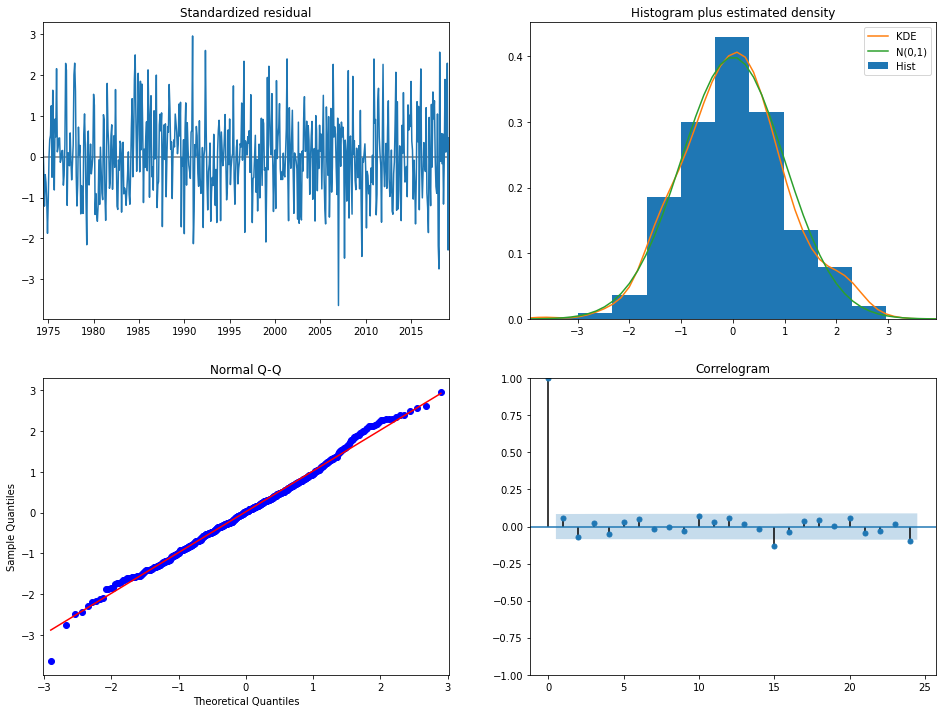

In [273]:
#Errors should follow normal distribution
#ACF of Errors - Error series should be white noise/random walk- There is no auto correlation among errors
model_sarima.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()

## Demand Estimation for Next 1-2 Years

In [266]:
#Forecasted values for next 24 months using Arima model!
arima=pd.Series(np.exp(model_arima.forecast(30)[0][-24:]),index=index_)

In [267]:
#Concatinating Forecasted values for next 24 months using ets, sarima, arima!
forecast_values=pd.concat([ets_model1.forecast(30)[-24:],np.exp(model_sarima.forecast(30))[-24:],arima],axis=1)
forecast_values.columns=['ETS_Forecast','SARIMA_Forecast','ARIMA_Foreccast']

In [268]:
forecast_values

,ETS_Forecast,SARIMA_Forecast,ARIMA_Foreccast
2019-10-01,93.485140,92.567330,90.672198
2019-11-01,91.702545,90.380134,89.718649
2019-12-01,101.157833,100.397246,88.817279
2020-01-01,106.639575,106.426788,87.964836
2020-02-01,99.027496,97.592440,87.158307
2020-03-01,94.703989,93.079799,86.394897
2020-04-01,88.922393,86.680885,85.672008
2020-05-01,94.042829,92.244842,84.987224
2020-06-01,107.411752,106.832641,84.338298
2020-07-01,117.725770,118.152918,83.723135


Refer the Detailed Report for which Model to be used and that model's forcasted values 
can be given to Leading Electricity Distributor!